<a href="https://colab.research.google.com/github/sreent/dense-neural-networks/blob/main/codes/CatVsDog%20-%20TFDS%20Color%20Binary%20Image%20Classification%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Defining the problem and assembling a dataset

- Tensorflow Cats Vs Dogs Dataset
  - https://www.tensorflow.org/datasets/catalog/cats_vs_dogs
- Binary Classification Problem

 ## Choosing a measure of success

- Accuracy Score
- F1 Score
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation and test sets
- Doing K-fold cross-validation

## Preparing your data

In [12]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import F1Score, AUC

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATASET = 'cats_vs_dogs'
RESIZE = (32, 32, 3)
GRAY_SCALE = True

In [3]:
ds = tfds.load(DATASET, split='all', shuffle_files=True)

images, labels = [], []
for entry in ds.take(len(ds)) :
    image, label = entry['image'], entry['label']

    image, label = image.numpy(), label.numpy()

    image = resize(image, RESIZE, anti_aliasing=True)

    if GRAY_SCALE :
        image = rgb2gray(image)

    images.append( image )
    labels.append( label )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incomplete17L1N4/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [4]:
# list of images to numpy array
X = np.array(images)

# binary output, 0 or 1
y = np.array(labels)

In [5]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y,
                                                    random_state=SEED, shuffle=True)

In [6]:
# normalise pixels from [0, 255] to [0, 1]
X_train, X_test = X_train/255, X_test/255

In [7]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

In [8]:
y_train, y_val, y_test = y_train.astype(float), y_val.astype(float), y_test.astype(float)

##  Developing a model that does better than a baseline

In [9]:
# number of samples per each class
# we consider this to be a balanced class since the counts are about the same
np.sum(y), len(y)-np.sum(y)

(11604, 11658)

In [10]:
# the class is off-balanced, but very minimal
naive_baseline = (len(y)-np.sum(y)) / len(y)

naive_baseline

0.5011606912561258

In [13]:
INPUT_DIMENSION = (32, 32, 1)
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           F1Score(name="f1_score", average='micro'),
           AUC(name="auc")]

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [14]:
baseline = Sequential(
    [
        Flatten(input_shape=INPUT_DIMENSION, name="flatten"),
        Dense(OUTPUT_DIMENSION, activation='sigmoid', input_shape=(INPUT_DIMENSION,))
    ],
    name="baseline"
)

baseline.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 1025 (4.00 KB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
batch_size = 64
EPOCHS = 200

In [16]:
learning_rate = 0.01

In [17]:
baseline.compile(optimizer=RMSprop(learning_rate=learning_rate),
                 loss=LOSS_FUNC, metrics=METRICS)

In [18]:
baseline_history = baseline.fit(X_train, y_train,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(X_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

In [19]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(baseline_scores[1]))
print('AUC (Validation): {:.2f}'.format(baseline_scores[2]))

Accuracy (Validation): 0.57 (Naive Baseline=0.50)
F1 Score (Validation): 0.67
AUC (Validation): 0.61


In [20]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

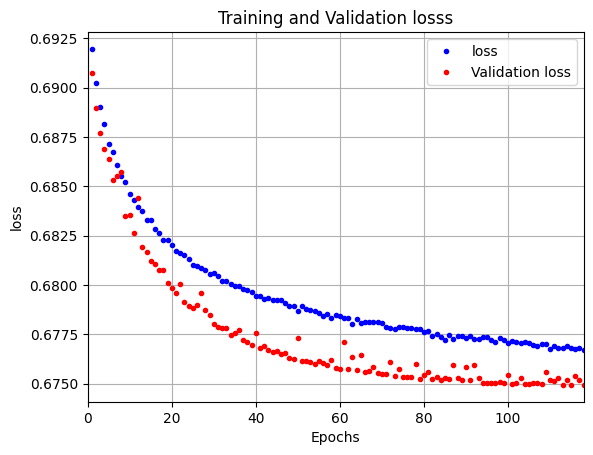

In [21]:
plot_training_history(baseline_history, monitor='loss')

 ## Scaling up: developing a model that overfits

In [22]:
overfit = Sequential(
    [
        Flatten(input_shape=INPUT_DIMENSION, name="flatten"),
        Dense(64, activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden"),
        Dense(OUTPUT_DIMENSION, activation="sigmoid", name="output")
    ],
    name="overfit"
)

overfit.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 hidden (Dense)              (None, 64)                65600     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 65665 (256.50 KB)
Trainable params: 65665 (256.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
learning_rate = 0.01

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=LOSS_FUNC, metrics=METRICS)

In [24]:
EPOCHS = 200
batch_size = 64

overfit_history = overfit.fit(X_train, y_train,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

In [25]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(overfit_scores[1]))
print('AUC (Validation): {:.2f}'.format(overfit_scores[2]))

Accuracy (Validation): 0.58 (Naive Baseline = 0.50)
F1 Score (Validation): 0.67
AUC (Validation): 0.60


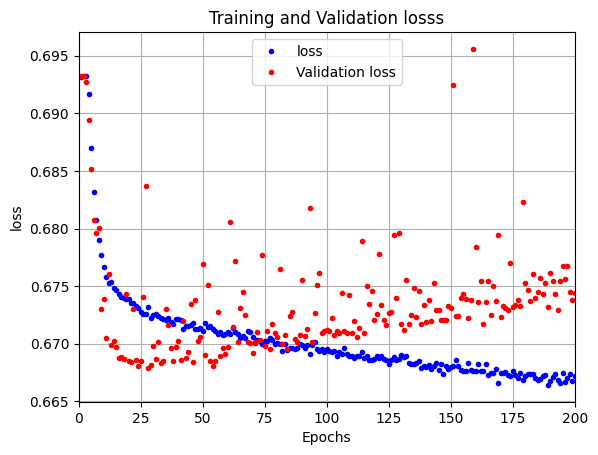

In [26]:
plot_training_history(overfit_history, monitor='loss')